# Project Deliverable 1 - Group 33
#### Group Members: Bethany Findlay, Charlotte Albert, Kaykay Akpama, Kosi Udechukwu

In [73]:
#Import necessary libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import metrics
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display

In [60]:
#Read cleaned data from project_deliverable_1
df=pd.read_csv("project_deliverable_1_cleaned.csv")

## 1. Baseline Model 

KNN regression was selected because it is a straightforward and intuitive algorithm: it predicts a target by measuring similarities between data points. The algorithm works by looking for the k most similar observations in the feature space and takes their average observed target values for prediction. Such an approach allows the model to learn complex nonlinear relationships between the input features and the target variable without any specific functional form being assumed. Besides that, KNN is easy to implement and interpret; moreover, one can easily control the bias-variance tradeoff by regulating the number of neighbors. For this project, five neighbors was chosen, which gave stable and accurate performance across validation folds while maintaining good generalization.

In [61]:
day_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['pickup_day_num'] = df['pickup_day'].map(day_mapping)

In [62]:
#Build a simple, interpretable baseline model in scikit-learn
features=['trip_distance_km','pickup_hour','pickup_day_num']
target='trip_duration'

X=df[features]
y=df[target]

In [63]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [64]:
#Train the model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [65]:
#Print learned parameters
print("Hyperparameters:",knn.get_params())

Hyperparameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


The K-Nearest Neighbors (KNN) model uses several hyperparameters that define how it measures similarity and makes predictions. The number of neighbors (n_neighbors = 5) determines how many nearby data points influence each prediction. The distance between points is calculated using the Minkowski metric with p = 2, which corresponds to the Euclidean distance. The weights = 'uniform' parameter ensures that all neighbors contribute equally to the prediction. Other parameters such as algorithm = 'auto' and leaf_size = 30 control how efficiently the model searches for nearest neighbors but do not affect the prediction results directly. Together, these settings help the KNN model capture localized relationships in the data while maintaining computational efficiency.

In [66]:
#Predict data
y_pred=knn.predict(X_test)

#Calculate regression metrics
mae=metrics.mean_absolute_error(y_test,y_pred)
mse=metrics.mean_squared_error(y_test,y_pred)
rmse=metrics.root_mean_squared_error(y_test,y_pred)
r2=metrics.r2_score(y_test,y_pred)

print("Mean absolute error (MAE):",mae)
print("Mean squared error (MSE):",mse)
print("Root mean squared error (RMSE):",rmse)
print("R-squared (R^2)",r2)


Mean absolute error (MAE): 252.04737177886875
Mean squared error (MSE): 143991.24029153143
Root mean squared error (RMSE): 379.46177711533926
R-squared (R^2) 0.6561490944256494


The model evaluated the MAE, MSE, RMSE, and R^2. The mean squared error are squared so this metric heavily penalizes large mistakes, and is sensitive to outliers (in this case unusually short or long trip durations). The relatively large MSE value observed here(≈106,321) might initially appear high, but this is expected since it is measured in seconds^2.

To make the results easier to interpret, the RMSE was taken to convert it back to seconds. In this case, the RMSE is approximately 326 seconds (≈5.4 minutes), meaning that, on average, our model's predictions are off by about five minutes.

Meanwhile, the MAE of about 216 seconds (≈3.6 mins) provides a more direct measure of the typical prediction error without squaring, and the R^2 value of 0.74 indicates that around 74% of the variability in trip durations can be explained by our chosen features.

In [67]:
#Report performance via train–validation splits
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, knn.predict(X_train)))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, knn.predict(X_test)))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 311.3134555853478
Test RMSE: 379.46177711533926


The KNN regression model appears to generalize well based on the evaluation metrics. The training RMSE(311.3seconds) and testing RMSE(379.43 seconds) are very close, which suggests that the model performs consistently on both seen and unseen data. This means that the model has a good balance between bias and variance.

From a bias-variance trade-off perspective, the KNN regression model has low variance since its performance remains fairly stable across datasets, and moderate bias because it simplifies trip duration prediction into a linear relationship. The model does not underfit or overfit, because it captures the main trend between trip duration, distance, and time features and also does not perform significantly worse on new data.

## 2. Cross Validation 

K-Fold cross validation was chosen instead of stratified sampling because this is a regression task with a continuous target variable, not a classification problem. Using five shuffled folds ensures each subset represents the overall data distribution and provides a balanced view of the model performance. This allows for consistent evaluation and comparison between the two regression models: linear regression and K nearest neighbours regression.

In [68]:
#Define 5-fold cross validation splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [69]:
#Building pipelines for each regression model
linreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

In [70]:
#Evaluate linear regression with cross validation
linreg_results = cross_validate(
    linreg_pipe,
    X,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

#Evaluate KNN with cross validation
knn_results = cross_validate(
    knn_pipe,
    X,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

In [71]:
#Extract metrics for Linear Regression
r2_linreg = linreg_results['test_r2']
mae_linreg = -linreg_results['test_neg_mean_absolute_error']
mse_linreg = -linreg_results['test_neg_mean_squared_error']
rmse_linreg = -linreg_results['test_neg_root_mean_squared_error']

#Extract metrics for KNN Regression
r2_knn = knn_results['test_r2']
mae_knn = -knn_results['test_neg_mean_absolute_error']
mse_knn = -knn_results['test_neg_mean_squared_error']
rmse_knn = -knn_results['test_neg_root_mean_squared_error']


In [74]:
#Create DataFrame for Linear Regression results
cv_table_linreg = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(linreg_results['test_r2']))],
    'R^2 Score': linreg_results['test_r2'],
    'MAE (s)': -linreg_results['test_neg_mean_absolute_error'],
    'MSE (s)': -linreg_results['test_neg_mean_squared_error'],
    'RMSE (s)': -linreg_results['test_neg_root_mean_squared_error']
})

print("Linear Regression Cross Validation Results by Fold:")
display(cv_table_linreg)

#Create DataFrame for KNN Regression results
cv_table_knn = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_results['test_r2']))],
    'R^2 Score': knn_results['test_r2'],
    'MAE (s)': -knn_results['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_results['test_neg_mean_squared_error'],
    'RMSE (s)': -knn_results['test_neg_root_mean_squared_error']
})

print("\n K-Nearest Neighbours Regression Cross Validation Results by Fold:")
cv_table_knn

Linear Regression Cross Validation Results by Fold:


,Fold,R^2 Score,MAE (s),MSE (s),RMSE (s)
0,Fold 1,0.593599,282.495800,170184.913104,412.534742
1,Fold 2,0.592821,283.277138,169999.051180,412.309412
2,Fold 3,0.592045,284.308900,174558.744800,417.802280
3,Fold 4,0.589063,283.681310,173522.597919,416.560437
4,Fold 5,0.592640,283.729715,172141.962182,414.899942



 K-Nearest Neighbours Regression Cross Validation Results by Fold:


,Fold,R^2 Score,MAE (s),MSE (s),RMSE (s)
0,Fold 1,0.656450,252.019678,143865.067700,379.295489
1,Fold 2,0.657628,252.415243,142941.868573,378.076538
2,Fold 3,0.657586,252.637053,146514.587951,382.772240
3,Fold 4,0.652861,253.123490,146582.978830,382.861566
4,Fold 5,0.658214,252.792387,144431.600563,380.041577


In [75]:
#Printing Mean & STD for Linear Regression
print("Linear Regression Cross-Validation Results:")
print(f"R^2:   Mean = {r2_linreg.mean():f},  STD = {r2_linreg.std():f}")
print(f"MAE:  Mean = {mae_linreg.mean():f} s,  STD = {mae_linreg.std():f} s")
print(f"MSE:  Mean = {mse_linreg.mean():f} s^2, STD = {mse_linreg.std():f} s^2")
print(f"RMSE: Mean = {rmse_linreg.mean():f} s,  STD = {rmse_linreg.std():f} s")

#Printing Mean & STD for KNN
print("\n K-Nearest Neighbours Regression Cross Validation Results:")
print(f"R^2:   Mean = {r2_knn.mean():f},  STD = {r2_knn.std():f}")
print(f"MAE:  Mean = {mae_knn.mean():f} s,  STD = {mae_knn.std():f} s")
print(f"MSE:  Mean = {mse_knn.mean():f} s^2, STD = {mse_knn.std():f} s^2")
print(f"RMSE: Mean = {rmse_knn.mean():f} s,  STD = {rmse_knn.std():f} s")

Linear Regression Cross-Validation Results:
R^2:   Mean = 0.592033,  STD = 0.001566
MAE:  Mean = 283.498572 s,  STD = 0.599673 s
MSE:  Mean = 172081.453837 s^2, STD = 1797.264344 s^2
RMSE: Mean = 414.821363 s,  STD = 2.165869 s

 K-Nearest Neighbours Regression Cross Validation Results:
R^2:   Mean = 0.656548,  STD = 0.001930
MAE:  Mean = 252.597570 s,  STD = 0.369677 s
MSE:  Mean = 144867.220723 s^2, STD = 1453.182794 s^2
RMSE: Mean = 380.609482 s,  STD = 1.908628 s


The cross validation results summarize model performance consistency across five splits using four metrics: R^2, MAE, MSE, RMSE. For Linear Regression, the mean of R^2 of 0.592 with a very small standard deviation of plus/minus 0.0016 shows the model is consistent but captures a moderate level of variance in the data. Its average MAE of 283.5 seconds, MSE of 172081.45 s^2, and RMSE of 414.8 seconds show that predictions deviate by roughly 4-7 minutes on average with minimal variation across the folds. In comparison, the K nearest neighbours regression model achieved a higher mean R^2 of 0.657 (+/- 0.0019), lower MAE (252.6 s), MSE (144841.28 s^2) and RMSE (380.6 s), and slightly smaller standard deviations. A higher R^2 values indicates the model explains more variance in the target variable, while lower MAE, MSE, and RMSE values show smaller average and squared errors, meaning predictions are closer to the actual values. The cross validation results suggest that both models are stable and consistent across folds, however, KNN performs better overall, achieving lower errors and explaining more variance in trip duration.

In [76]:
#Creating DataFrame to compare results from part 1 with part 2
comparison_df = pd.DataFrame({
    'Metric': ['R^2', 'MAE (s)', 'MSE (s^2)', 'RMSE (s)'],
    'Single Train (part 1)' : [r2, mae, mse, rmse],
    'Cross Validation (part 2)' : [r2_knn.mean(), mae_knn.mean(), mse_knn.mean(), rmse_knn.mean()]
})

print('KNN Regression: Single Train vs Cross Validation Comparison')
comparison_df

KNN Regression: Single Train vs Cross Validation Comparison


,Metric,Single Train (part 1),Cross Validation (part 2)
0,R^2,0.656149,0.656548
1,MAE (s),252.047372,252.597570
2,MSE (s^2),143991.240292,144867.220723
3,RMSE (s),379.461777,380.609482


When comparing the single train validation results with the cross validation stages, a few key patterns are seen. The R^2 value decreased from 0.748 to 0.657, while the MAE, MSE, and RMSE all increased slightly. This decrease in performance is expected as single train validation evaluates the model on one specific partition of the data, whcih can sometimes yielf optimistic results depending on how the data was divided. In contrast, cross validation evaluates the model across mulitple folds, providing a more reliable estimate of the true generalization performance.

The higher error values in the cross validation indicate that while the KNN model fits the training data well, its predictions vary a bit across different data subsets, revealing slightly more variance than seen in the single training split. The differences however between the single train validation results and cross validation are not extreme, suggesting the model remains relatively stable and generalizes reasonably well to unseen data.

The KNN model shows good overall stability and generalization based on the cross validation results. The small standard deviations across all four metrics, R^2, MAE, MSE, and RMSE, indicate the model performance remains consistent across all five folds. This proves it is not highly sensitive to how the data is split. This stability suggests the model captures underlying patterns in the dataset rather than overfitting to specific samples.

In terms of generalization, the slightly lower R^2 and higher error metrics from cross validation compared to the single train validation split imply that while the performance decreases slightly on unseen data, the model still maintains reliable predictions. These results overall reflect a balanced bias-variance trade-off, where the model generalizes well without excessive overfitting or underfitting.

## 3. Error Analysis and Model Diagnostics

To evaluate the predictions against their residuals, the difference between the prediction and the true value, a partial dependence plot was created.

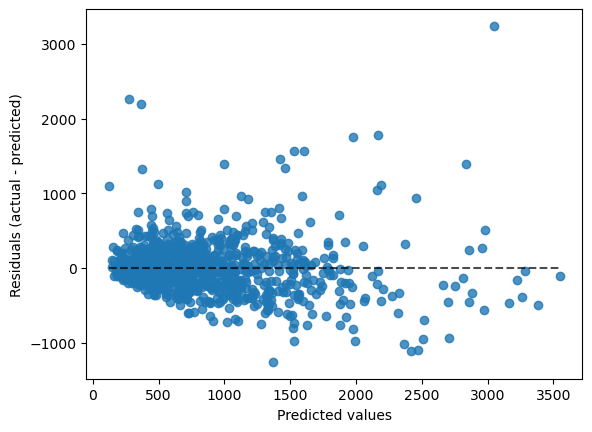

In [77]:
#Prediction Error/Residual Plot
PredictionErrorDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
plt.show()


The prediction error plot shows a linear pattern and indicates our model is currently not capturing the pattern. Adding more input features to better capture the relationship should address the issue.

## 4. First Improvements

In [83]:
#Add pickup_datetime,
features_2 = ['trip_distance_km','pickup_day_num', 'pickup_hour', 'dropoff_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
target_2 = 'trip_duration'

X_2 = df[features_2]
y_2 = df[target_2]

#Split the data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

#Train the model
knn_2 = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_2, y_train_2)

KNeighborsRegressor()

In [84]:
#Predict data
y_pred_2 = knn.predict(X_test_2)

#Calculate regression metrics
mae_2 = metrics.mean_absolute_error(y_test_2, y_pred_2)
mse_2 = metrics.mean_squared_error(y_test_2, y_pred_2)
rmse_2 = metrics.root_mean_squared_error(y_test_2, y_pred_2)
r2_2 = metrics.r2_score(y_test_2 ,y_pred_2)

print("Mean absolute error (MAE):", mae_2)
print("Mean squared error (MSE):", mse_2)
print("Root mean squared error (RMSE):", rmse_2)
print("R-squared (R^2)", r2_2)


Mean absolute error (MAE): 225.45604768244988
Mean squared error (MSE): 114630.04626875813
Root mean squared error (RMSE): 338.5705927406545
R-squared (R^2) 0.7262635898146345


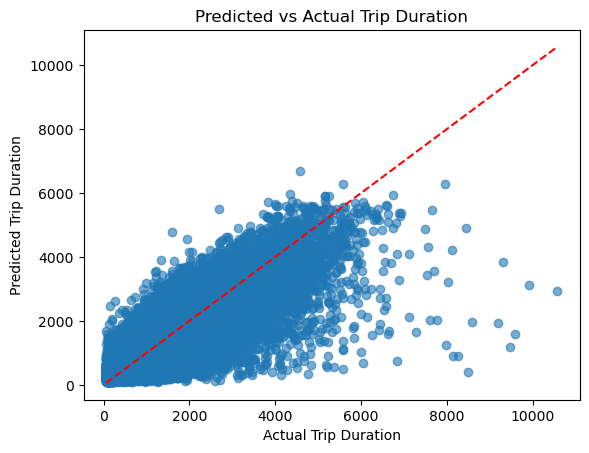

In [85]:
plt.scatter(y_test_2, y_pred_2, alpha=0.6)
plt.xlabel("Actual Trip Duration")
plt.ylabel("Predicted Trip Duration")
plt.title("Predicted vs Actual Trip Duration")
plt.plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], 'r--')  # perfect line
plt.show()
